In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pathlib
import os
import datetime
import time
import keras_cv
import random
from sklearn.model_selection import train_test_split

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'

flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
# tulips 클래스 이미지 경로 가져오기
tulips_dir = data_dir / 'tulips'
tulips_images = list(tulips_dir.glob('*.jpg'))

# 다른 클래스에서 각각 1개의 이미지만 가져오기
other_images = []
for flower_class in flowers_classes:
    if flower_class != 'tulips':
        class_dir = data_dir / flower_class
        image_files = list(class_dir.glob('*.jpg'))
        if image_files:
            other_images.append(image_files[0])  # 각 클래스에서 첫 번째 이미지만 추가

# Validation 데이터셋 생성 (tulips만)
val_tulips_images = tulips_images[:553]  # 0~552번까지
train_tulips_images = tulips_images[553:]  # 553번부터 나머지

# Train 데이터셋 생성 (tulips 나머지 + 다른 클래스 1개씩)
train_image_paths = train_tulips_images + other_images
train_labels = ['tulips'] * len(train_tulips_images) + [flower_class for flower_class in flowers_classes if flower_class != 'tulips']

# Validation 데이터셋 생성 (tulips만)
val_image_paths = val_tulips_images
val_labels = ['tulips'] * len(val_tulips_images)

# 클래스 이름 목록 및 클래스 수
class_names = np.unique(train_labels)
num_classes = len(class_names)

# 이미지 크기 및 배치 설정
img_height = 100
img_width = 100
batch_size = 32

# 데이터 증강 설정
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 이미지 경로와 레이블을 이용하여 tf.data.Dataset 생성
def create_dataset(image_paths, labels):
    image_paths = [str(path) for path in image_paths]
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3))
    image_ds = image_ds.map(lambda x: tf.image.resize(x, [img_height, img_width]))

    label_map = {label: index for index, label in enumerate(class_names)}
    numerical_labels = [label_map[label] for label in labels]
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(numerical_labels, tf.int32))

    dataset = tf.data.Dataset.zip((image_ds, label_ds))
    return dataset.batch(batch_size)

# Train 데이터셋 생성 (데이터 증강 포함)
train_ds = create_dataset(train_image_paths, train_labels)

# Validation 데이터셋 생성 (증강 없이)
val_ds = create_dataset(val_image_paths, val_labels)

# 데이터셋 캐시 및 prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 출력: 데이터셋 정보 확인
print(f"Train dataset size: {len(train_image_paths)} images")
print(f"Validation dataset size: {len(val_image_paths)} images")
print(f"Number of classes: {num_classes}")


Train dataset size: 250 images
Validation dataset size: 553 images
Number of classes: 5


In [ ]:
pd.DataFrame(train_labels).value_counts()

,count
0,
tulips,246
daisy,1
dandelion,1
roses,1
sunflowers,1


In [ ]:
pd.DataFrame(val_labels).value_counts()

,count
0,
tulips,553


In [ ]:
train_count = sum(1 for _ in train_ds.unbatch())
val_count = sum(1 for _ in val_ds.unbatch())

print("Train 데이터 개수:", train_count)
print("Validation 데이터 개수:", val_count)

Train 데이터 개수: 250
Validation 데이터 개수: 553


<Figure size 1500x500 with 0 Axes>

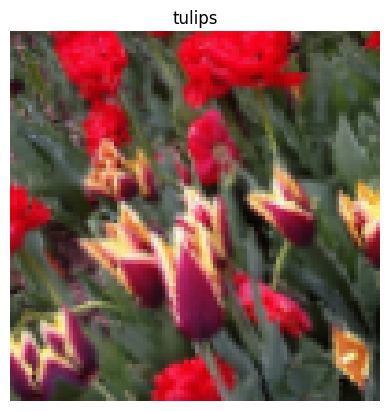

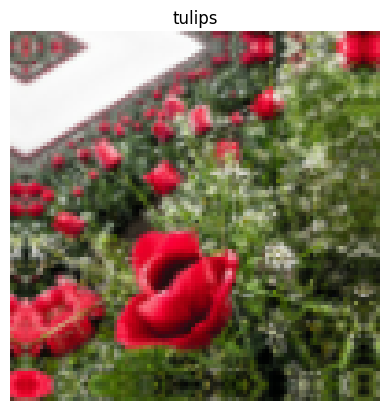

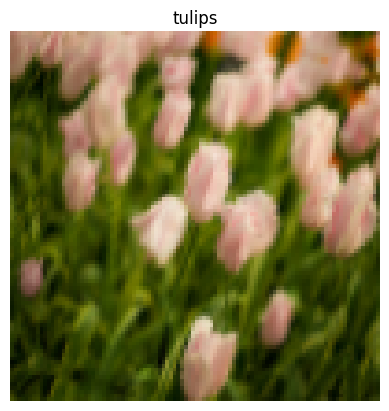

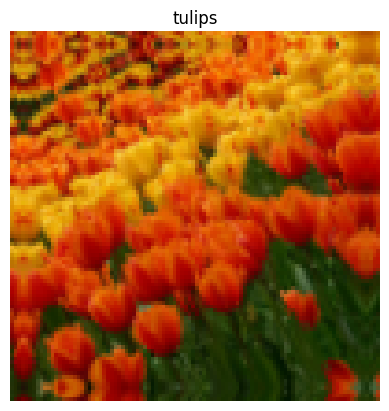

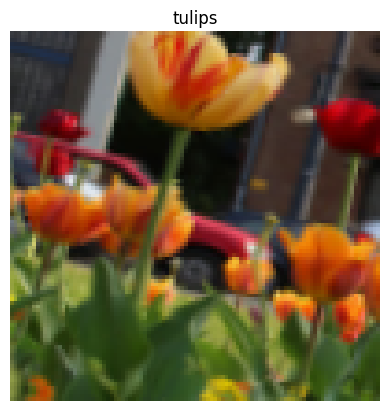

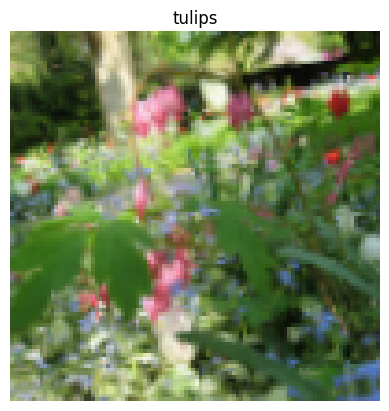

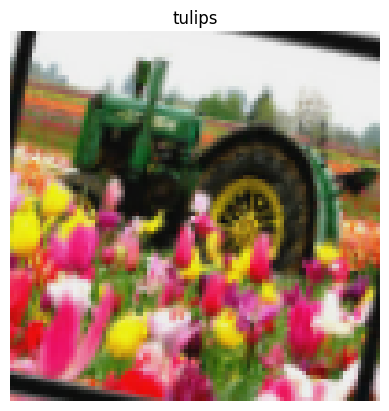

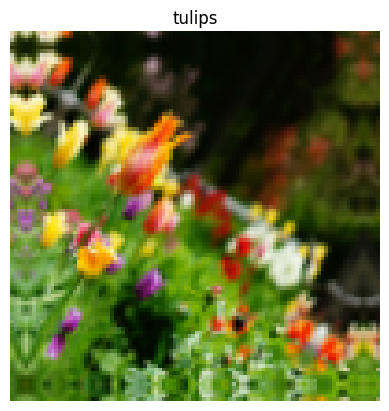

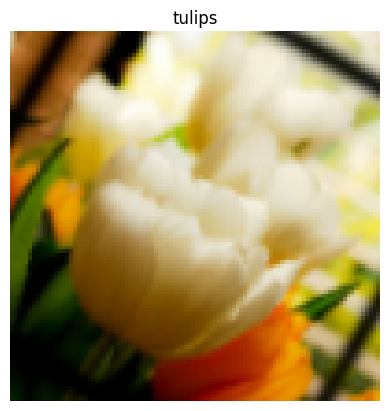

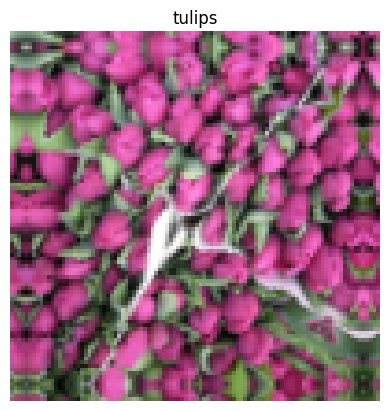

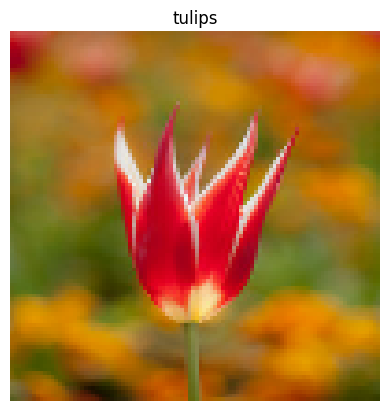

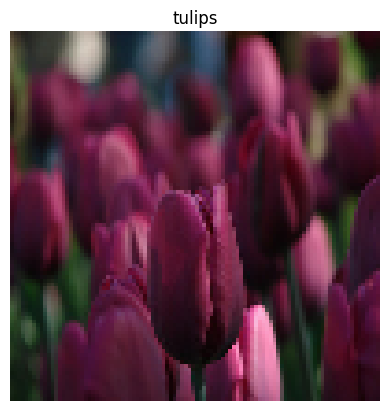

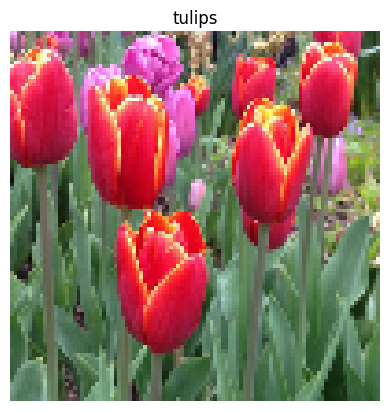

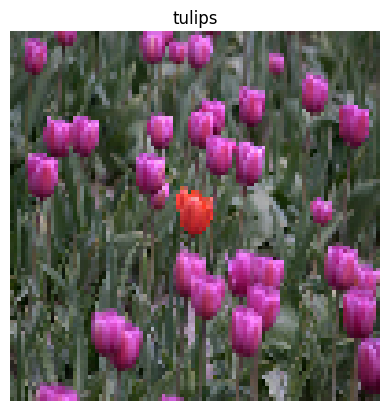

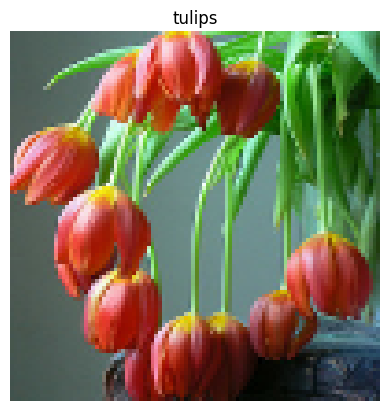

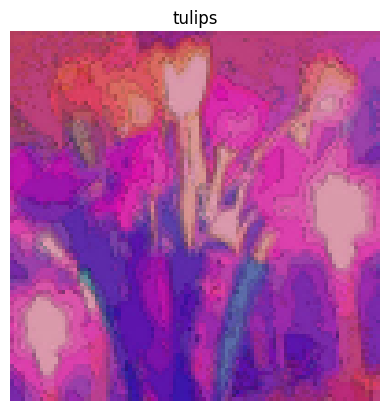

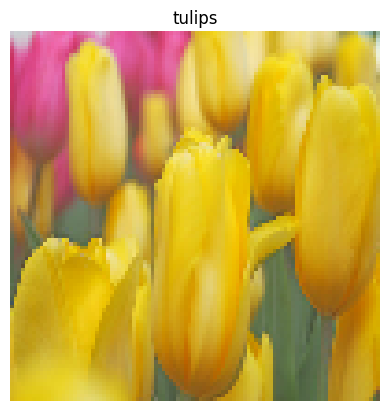

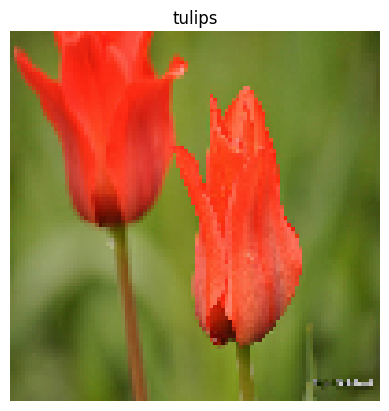

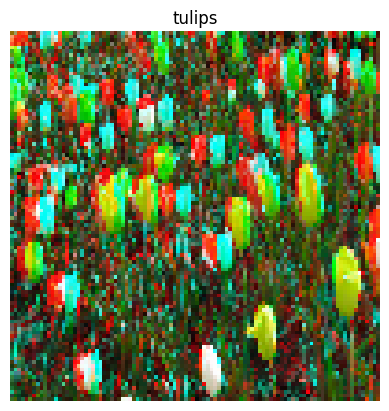

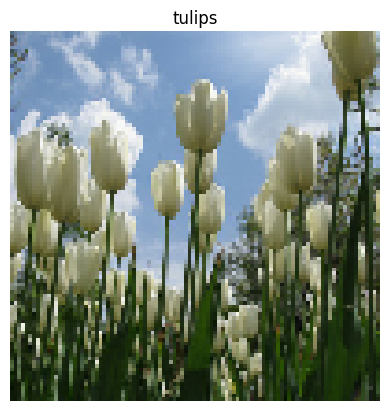

In [ ]:
# prompt: train_ds, val_ds 에서 10장씩 추춣서 이미지르,ㄹ 출력

import matplotlib.pyplot as plt

# 10개의 이미지와 라벨을 추출
plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):  # train_ds에서 첫 번째 배치만 가져옴
  for i in range(10):
    plt.figure()
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.show()
print("\n")
for images, labels in val_ds.take(1):  # val_ds에서 첫 번째 배치만 가져옴
  for i in range(10):
    plt.figure()
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.show()


In [ ]:
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'

flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
# tulips 클래스 이미지 경로 가져오기
tulips_dir = data_dir / 'tulips'
tulips_images = list(tulips_dir.glob('*.jpg'))

# 다른 클래스에서 각각 1개의 이미지만 가져오기
other_images = []
for flower_class in flowers_classes:
    if flower_class != 'tulips':
        class_dir = data_dir / flower_class
        image_files = list(class_dir.glob('*.jpg'))
        if image_files:
           other_images.append(image_files[0])  # 각 클래스에서 첫 번째 이미지만 추가

# Train 데이터셋 생성 (tulips 전체와 다른 클래스 각 1개)
train_image_paths = tulips_images + other_images
train_labels = ['tulips'] * len(tulips_images) + [flower_class for flower_class in flowers_classes if flower_class != 'tulips']

class_names = np.unique(train_labels)  # 레이블 목록 업데이트
num_classes = len(class_names)

# Validation 데이터셋 생성 (tulips만)
val_image_paths = tulips_images
val_labels = ['tulips'] * len(tulips_images)


img_height = 100
img_width = 100
batch_size = 32

# 이미지 경로와 레이블을 이용하여 tf.data.Dataset 생성
def create_dataset(image_paths, labels):
    image_paths = [str(path) for path in image_paths]
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3))
    image_ds = image_ds.map(lambda x: tf.image.resize(x, [img_height, img_width]))

    label_map = {label: index for index, label in enumerate(class_names)}
    numerical_labels = [label_map[label] for label in labels]
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(numerical_labels, tf.int32))

    dataset = tf.data.Dataset.zip((image_ds, label_ds))
    return dataset.batch(batch_size)

train_ds = create_dataset(train_image_paths, train_labels)
val_ds = create_dataset(val_image_paths, val_labels)


class_names = np.unique(train_labels) # 레이블 목록 업데이트
num_classes = len(class_names)

# 데이터 증강
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
normalization_layer = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


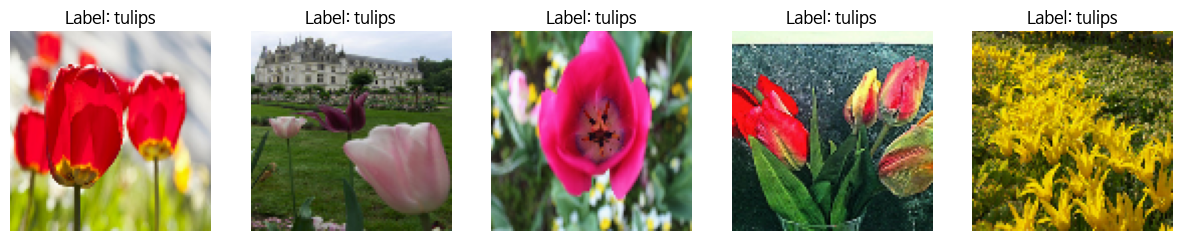

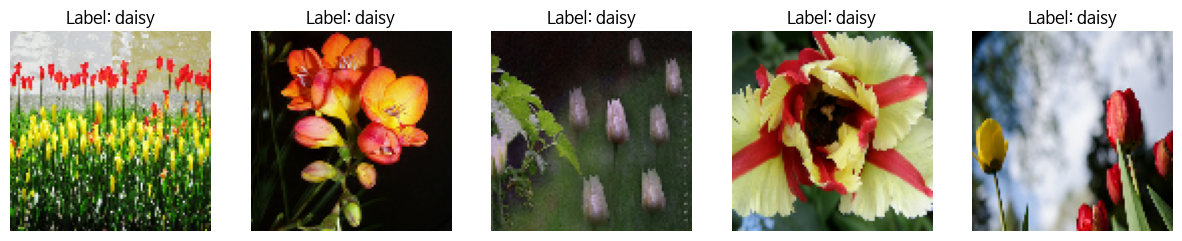

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):  #5장만 출력
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()


In [ ]:
def build_attention_cnn():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = layers.Conv2D(16, 1, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)

    # Attention
    shape = tf.keras.backend.int_shape(x)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# def build_attention_cnn():
#     # 기본 CNN-AT
#     inputs = keras.Input(shape=(img_height, img_width, 3))
#     x = data_augmentation(inputs)
#     x = normalization_layer(x)
#     x = layers.Conv2D(32, 3, activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, 3, activation='relu')(x)
#     x = layers.MaxPooling2D()(x)
#     x = layers.LayerNormalization()(x)

#     # Attention
#     shape = tf.keras.backend.int_shape(x)
#     x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
#     x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
#     x = layers.GlobalAveragePooling1D()(x)

#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)
#     model = keras.Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

Evaluating and plotting Attention-CNN ...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 100, 100,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 100, 100,  │          0 │ sequential_3[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │         64 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 50,    │         32 │ max_pooling2d[0]… │
│ (LayerNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 2500, 16)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2500, 16)  │      4,304 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        165 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,109 (19.96 KB)

 Trainable params: 5,109 (19.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 18s/step - accuracy: 0.1613 - loss: 1.6568 - val_accuracy: 1.0000 - val_loss: 1.1934
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 154s 21s/step - accuracy: 0.8791 - loss: 1.1023 - val_accuracy: 1.0000 - val_loss: 0.6649
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 133s 18s/step - accuracy: 0.9386 - loss: 0.6787 - val_accuracy: 1.0000 - val_loss: 0.2462
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 18s/step - accuracy: 0.9501 - loss: 0.3901 - val_accuracy: 1.0000 - val_loss: 0.0620
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 18s/step - accuracy: 0.9455 - loss: 0.3481 - val_accuracy: 1.0000 - val_loss: 0.0196
Attention-CNN 모델 정확률 = 100.00%
Attention-CNN 모델 파라미터 = 5,109


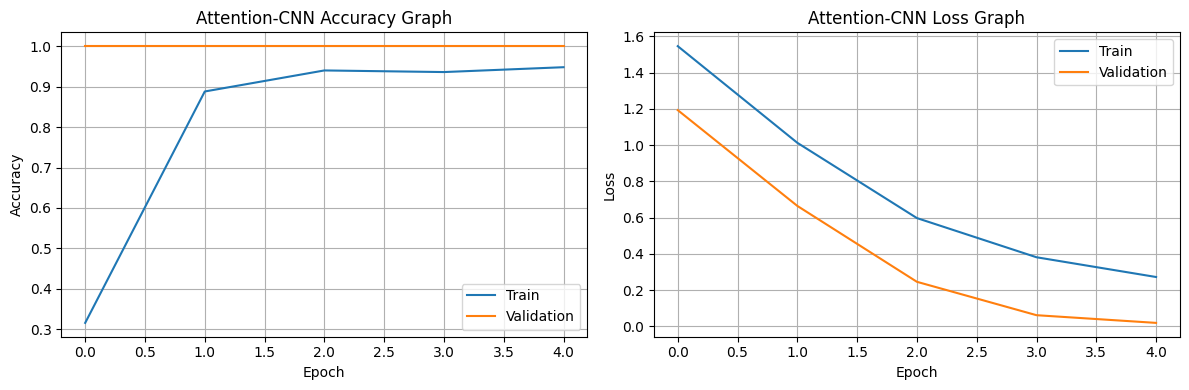

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time


model_builders = {
    "Attention-CNN": build_attention_cnn,
}

results = []
all_results = []
EPOCHS = 5

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    dummy_input = tf.zeros((1, img_height, img_width, 3))
    _ = model(dummy_input)

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확률 = {test_accuracy * 100:.2f}%')
    print(f'{name} 모델 파라미터 = {trainable_params:,}')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([{
    '모델': r['model_name'],
    '정확도 (%)': r['test_accuracy'],
    '손실': r['test_loss'],
    '총 파라미터 수': r['total_params'],
    '훈련 가능한 파라미터': r['trainable_params'],
    '훈련 시간 (초)': r['training_time']
} for r in all_results])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 최적 모델 선정
max_accuracy_model = results_df.loc[results_df['정확도 (%)'].idxmax()]
min_params_model = results_df.loc[results_df['총 파라미터 수'].idxmin()]

print(f"\n모델: {max_accuracy_model['모델']}")
print(f"정확도: {max_accuracy_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {max_accuracy_model['총 파라미터 수']:,}")


모델 성능 비교 테이블:
           모델  정확도 (%)       손실  총 파라미터 수  훈련 가능한 파라미터  훈련 시간 (초)
Attention-CNN    100.0 0.077549      5109         5109  20.412246

모델: Attention-CNN
정확도: 100.00%
총 파라미터 수: 5,109
